Here we are loading the raw training data

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm

train_df = pd.read_csv("/Users/bogdansandoiu/Documents/Neural Networks/Stocks Forecasting/Stocks-forecasting/data/raw/train_wide.csv")
train_df.head()

,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988
0,940.66,1084.86,1244.98,1445.02,1683.17,2038.15,2342.52,2602.45,2927.87,3103.96,3360.27,3807.63,4387.88,4936.99
1,1991.05,2306.40,2604.00,2992.30,3722.08,5226.62,5989.46,5614.62,5527.00,5389.80,5384.40,3656.20,4034.80,4230.00
2,1461.57,1692.50,2193.82,2459.68,3246.80,4748.86,5559.46,5292.42,5029.40,4753.60,4344.60,2897.40,3256.40,3525.20
3,744.54,1105.16,1417.40,1838.04,2337.62,3094.88,4280.04,5070.20,3675.18,3667.38,3808.64,3114.42,3847.20,4632.30
4,4977.18,5248.00,5370.00,6184.89,7137.19,6743.00,7298.00,5260.29,4898.18,5392.04,5117.64,4332.90,4620.50,5488.80


Here we are plotting the first training samples 

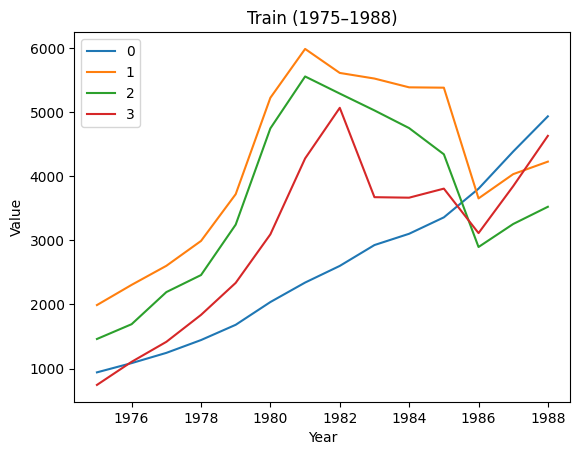

In [104]:
years = train_df.columns.astype(int)
ax = plt.figure().gca()
for sid in range(4):    
    y = pd.Series(train_df.loc[sid].to_numpy(), index=pd.PeriodIndex(years, freq="Y")) 
    index = y.index.to_timestamp() 
    ax.plot(index, y.values, label=sid)

ax.set_xlabel("Year")
ax.set_ylabel("Value")
ax.set_title("Train (1975–1988)")
ax.legend()
plt.show()

Detrending and Deseasoning using the statsmodel with multiplicative

In [105]:

trend_components = []
seasonal_components = []
residual_components = []

for i, (_, row) in enumerate(tqdm(train_df.iterrows(), total=len(train_df))):
    y = pd.Series(row.to_numpy(), index=pd.PeriodIndex(years, freq="Y"))

    result = seasonal_decompose(y, model='multiplicative', period=1)

    trend_components.append(result.trend.to_numpy())
    seasonal_components.append(result.seasonal.to_numpy())
    residual_components.append(result.resid.to_numpy())

# convert to DataFrames
trend_df = pd.DataFrame(trend_components, columns=train_df.columns)
seasonal_df = pd.DataFrame(seasonal_components, columns=train_df.columns)
residual_df = pd.DataFrame(residual_components, columns=train_df.columns)

100%|██████████| 145/145 [00:00<00:00, 4337.07it/s]


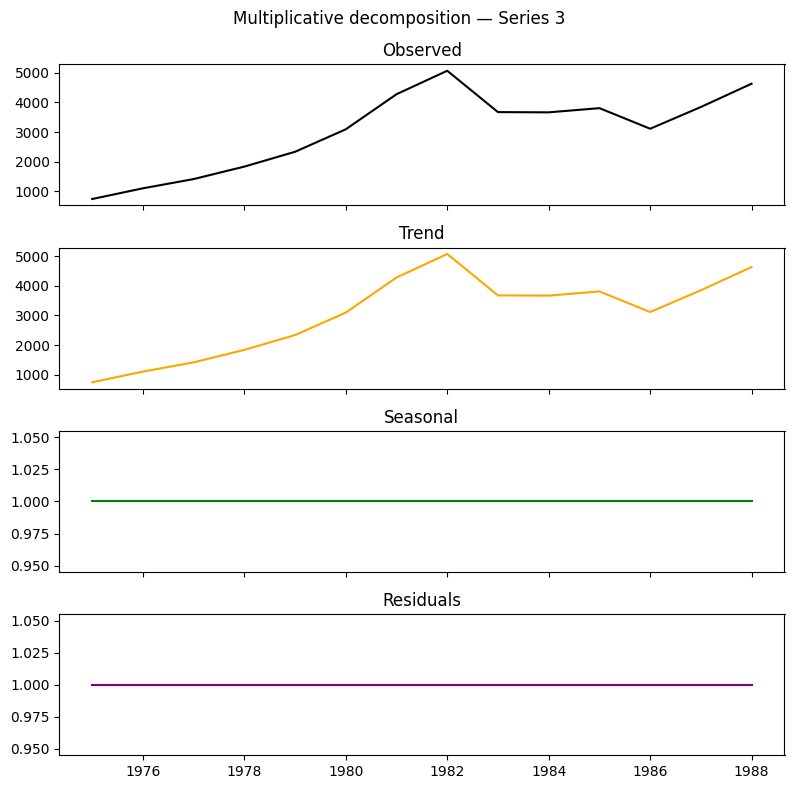

In [106]:
def plot_multiplicative_decomposition(sid):
    y = pd.Series(train_df.loc[sid].to_numpy(float),
                  index=pd.PeriodIndex(years, freq='Y'))

    res = seasonal_decompose(y, model='multiplicative', period=1)

    fig, axes = plt.subplots(4, 1, figsize=(8, 8), sharex=True)
    axes[0].plot(y.index.to_timestamp(), y.values, label="Observed", color='black')
    axes[0].set_title("Observed")
    axes[1].plot(res.trend.index.to_timestamp(), res.trend, color='orange')
    axes[1].set_title("Trend")
    axes[2].plot(res.seasonal.index.to_timestamp(), res.seasonal, color='green')
    axes[2].set_title("Seasonal")
    axes[3].plot(res.resid.index.to_timestamp(), res.resid, color='purple')
    axes[3].set_title("Residuals")
    plt.suptitle(f"Multiplicative decomposition — Series {sid}")
    plt.tight_layout()
    plt.show()

plot_multiplicative_decomposition(3)


Here we are training a Polynomial Linear Regression to detrend the data